In [ ]:
!pip install remotezip tqdm opencv-python einops
!pip install -U tensorflow keras

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
import time

In [ ]:
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense
from keras import initializers
from keras.regularizers import l2
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.optimizers import Adam

from tensorflow.keras import utils
import random

In [ ]:

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (50,50), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = int(video_length - need_length)
    start = random.randint(0, int(max_start + 1)) # Cast to int


  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL,
                        num_classes = 10,
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████| 300/300 [00:36<00:00,  8.25it/s]


val :


100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


test :


100%|██████████| 100/100 [00:08<00:00, 12.30it/s]


**Create the training, validation, and test sets (train_ds, val_ds, and test_ds).**

In [ ]:
import tensorflow as tf

def rate_encode_avg(video, time_steps=10):
    """
    Rate-encodes video frames into spike trains and averages over spike time steps.

    Args:
        video: Tensor of shape (batch, n_frames, H, W, C), values in [0, 1].
        time_steps: Number of spike time steps.

    Returns:
        averaged_spikes: Tensor of same shape as input (batch, n_frames, H, W, C),
                         representing average firing rate per pixel.
    """
    # Ensure pixel values are in [0, 1]
    video = tf.clip_by_value(video, 0.0, 1.0)

    # Generate random thresholds: one for each time step
    rand_thresh = tf.random.uniform(
        shape=(tf.shape(video)[0], time_steps, *video.shape[1:]),
        dtype=video.dtype
    )

    # Compare each threshold to pixel intensity
    spikes = tf.cast(rand_thresh < tf.expand_dims(video, axis=1), tf.float32)

    # Average spikes over spike time dimension
    averaged_spikes = tf.reduce_mean(spikes, axis=1)

    return averaged_spikes

    for spikes, labels in train_ds_encoded.take(1):
      print(spikes.shape)

IndentationError: expected an indented block after 'for' statement on line 32 (ipython-input-447670087.py, line 33)

In [ ]:
n_frames = 10
batch_size = 8
output_size = (50, 50) # Define output_size here as it's used in output_signature
num_of_classes = 10 # Define num_of_classes here as it's used in one_hot encoding

output_signature = (tf.TensorSpec(shape = (n_frames, output_size[0], output_size[1], 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int64)) # Changed dtype to tf.int64

# Create FrameGenerators
train_gen = FrameGenerator(subset_paths['train'], n_frames, training=True)
val_gen = FrameGenerator(subset_paths['val'], n_frames)
test_gen = FrameGenerator(subset_paths['test'], n_frames)

# Create tf.data.Datasets from the generators and batch them
train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen(), output_signature=output_signature)
train_ds = train_ds.map(lambda frames, labels: (frames, tf.one_hot(labels, num_of_classes))) # Apply one-hot encoding
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_gen(), output_signature=output_signature)
val_ds = val_ds.map(lambda frames, labels: (frames, tf.one_hot(labels, num_of_classes))) # Apply one-hot encoding
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_generator(
    lambda: test_gen(), output_signature=output_signature)
test_ds = test_ds.map(lambda frames, labels: (frames, tf.one_hot(labels, num_of_classes))) # Apply one-hot encoding
test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Create a FrameGenerator instance for one of the datasets (e.g., training)
# You can use any of the paths from subset_paths dictionary
example_gen = FrameGenerator(subset_paths['train'], n_frames)

# Access and print the class names
print(example_gen.class_names)

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress']


In [ ]:
time_steps = 10  # number of spike samples per input

def add_rate_encoding(frames, labels):
    encoded_frames = rate_encode_avg(frames, time_steps=time_steps)
    return encoded_frames, labels

train_ds_encoded = train_ds.map(add_rate_encoding, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_encoded = val_ds.map(add_rate_encoding, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Create a FrameGenerator instance for one of the datasets (e.g., training)
# You can use any of the paths from subset_paths dictionary
example_gen = FrameGenerator(subset_paths['train'], n_frames)

# Access and print the class names
print(example_gen.class_names)

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress']


### **Classification Training Model - Conv3D Video Classification**

In [ ]:
#Rate encoding limited num neural network model definition
from keras.layers import Conv3D, MaxPooling3D, InputLayer, Reshape

def create_model():
  model = Sequential()
  # Explicitly add an InputLayer
  model.add(InputLayer(input_shape=(10, 50, 50, 3)))
  # Add 3D convolutional layers to process video data
  model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2))) # Reduced pool size
  model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2))) # Reduced pool size
  model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2))) # Reduced pool size
  model.add(Flatten()) # Flatten the output of convolutional layers
  # Add Dense layers
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5)) # Add dropout for regularization
  model.add(Dense(num_of_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.0001), # Adjusted learning rate
                loss='categorical_crossentropy',
               metrics=['accuracy'])
  return model

# Assuming x_train, y_train, x_test, y_test are available from previous steps if needed for printing shapes
# print(np.mean(x_train), np.std(x_train))

In [ ]:
#!!!Run this block of code and all below

model = create_model()
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 8, 48, 48, 32)  │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 8, 24, 24, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 6, 22, 22, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 6, 11, 11, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 4, 9, 9, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 4, 4, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,290 (5.07 MB)

 Trainable params: 1,329,290 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
T0 = time.time()
# Train
history = model.fit(
    train_ds_encoded,
    validation_data=val_ds_encoded,
    epochs=50,
    verbose=1
)
T1 = time.time()
Train_T = T1 - T0

Epoch 1/50
     59/Unknown 71s 968ms/step - accuracy: 0.1231 - loss: 2.2953

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


59/59 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.1567 - loss: 2.2660 - val_accuracy: 0.2540 - val_loss: 2.1598
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.2339 - loss: 2.1116 - val_accuracy: 0.2963 - val_loss: 1.9697
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.2854 - loss: 1.9658 - val_accuracy: 0.3439 - val_loss: 1.8742
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.3734 - loss: 1.7934 - val_accuracy: 0.4233 - val_loss: 1.6498
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.4292 - loss: 1.6198 - val_accuracy: 0.4286 - val_loss: 1.5707
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4356 - loss: 1.5104 - val_accuracy: 0.4603 - val_loss: 1.4004
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 635ms/step - accuracy: 0.4893 - loss: 1.4647 - val_accuracy: 0.5714 - val_loss: 1.3186
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5300 - loss: 1.3668 - val_accuracy: 0.6032 - val_loss:

In [ ]:
# Inspect the shape of data from the training dataset
for frames, labels in train_ds.take(1):
  print("Shape of frames batch:", frames.shape)
  print("Shape of labels batch:", labels.shape)

Shape of frames batch: (8, 10, 50, 50, 3)
Shape of labels batch: (8, 10)


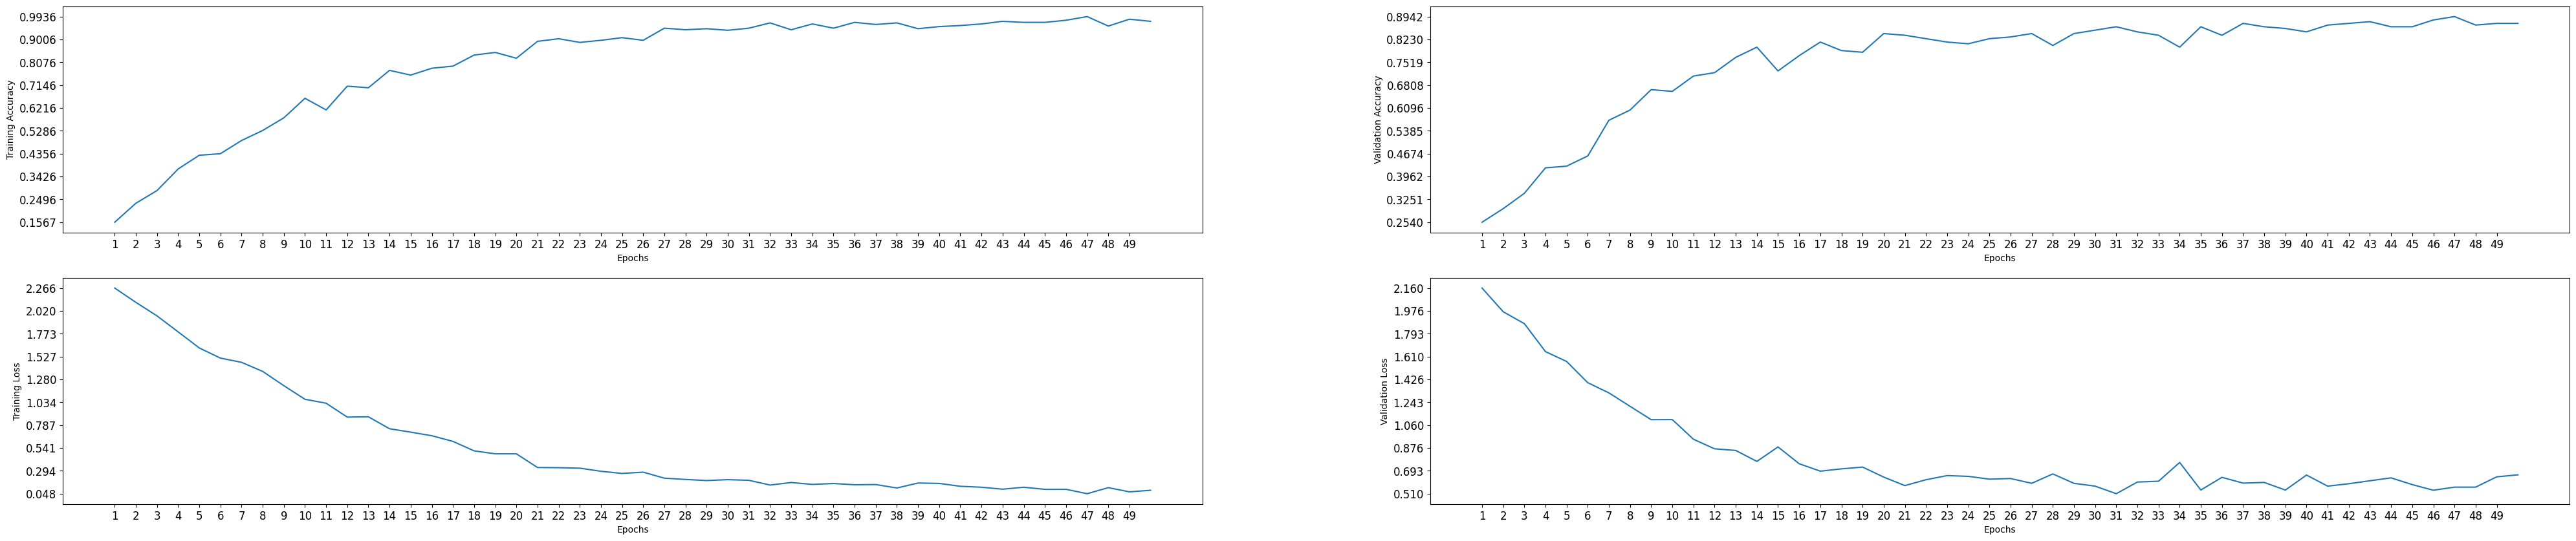

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (50, 10) )
train_x = range(1, len(history.history["accuracy"])+1)
train_y = history.history["accuracy"]
train_loss = history.history["loss"]
ax[0,0].plot(train_x, train_y)
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Training Accuracy")
ax[0,0].set_xticks(range(1, 50))
ax[0,0].tick_params(axis = "both", labelsize = 12)
ax[0,0].set_yticks(np.linspace(start = min(train_y), stop = max(train_y), num = 10))

val_x = range(1, len(history.history["val_accuracy"])+1)
val_y = history.history["val_accuracy"]
ax[0,1].plot(val_x , val_y)
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Validation Accuracy")
ax[0,1].set_xticks(range(1, 50))
ax[0,1].set_yticks(np.linspace(start = min(val_y), stop = max(val_y), num = 10))
ax[0,1].tick_params(axis = "both", labelsize = 12)

train_loss = history.history["loss"]
ax[1,0].plot(train_x, train_loss)
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Training Loss")
ax[1,0].set_xticks(range(1, 50))
ax[1,0].tick_params(axis = "both", labelsize = 12)
ax[1,0].set_yticks(np.linspace(start = min(train_loss), stop = max(train_loss), num = 10))

val_loss = history.history["val_loss"]
ax[1,1].plot(train_x, val_loss)
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Validation Loss")
ax[1,1].set_xticks(range(1, 50))
ax[1,1].tick_params(axis = "both", labelsize = 12)
ax[1,1].set_yticks(np.linspace(start = min(val_loss), stop = max(val_loss), num = 10))

plt.show()

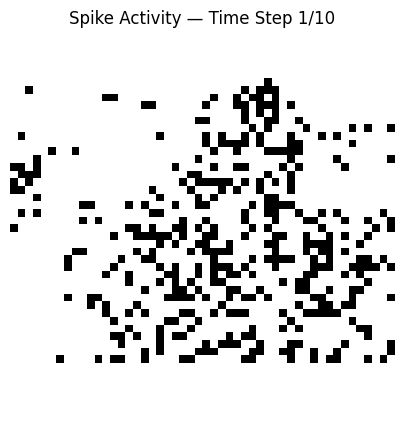

In [ ]:
# --- grab one video sample from your dataset ---
for frames, _ in train_ds.take(1):
    sample_video = frames[0:1]  # shape (1, n_frames, 50, 50, 3)
    break

# Encode it
time_steps = 10
spikes = rate_encode(sample_video, time_steps)
spikes_np = spikes.numpy()  # (1, T, n_frames, H, W, C)

# Choose which frame + channel to visualize
frame_idx = 5
channel_idx = 1  # R=0, G=1, B=2

# Extract spikes over time for that frame & channel
spike_activity = spikes_np[0, :, frame_idx, :, :, channel_idx]  # (T, H, W)

# --- create animation ---
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(spike_activity[0], cmap="binary", vmin=0, vmax=1)
ax.set_title(f"Spike Frames over Time (Frame {frame_idx}, Channel {channel_idx})")
ax.axis("off")

def update(frame_idx_anim):
    im.set_data(spike_activity[frame_idx_anim])
    ax.set_title(f"Spike Activity — Time Step {frame_idx_anim+1}/{time_steps}")
    return [im]

anim = FuncAnimation(fig, update, frames=time_steps, interval=400, blit=True)

plt.show()
anim.save("spike_activity.gif", writer="pillow", fps=2)